In [1]:
import aomip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from tifffile import imsave, imread
import json
from os.path import join
from skimage.io import imread, imsave
import tifffile

pyelsa not build with CUDA projector support


Optional call back to save history

In [2]:
fs = []
fy = []
step = 1
def callback1(x,y,i):
    if i % step == 0:
        fs.append(x)
        fy.append(y)
             

## Homework 1: Proximal Optimized Gradient Method (POGM)

In [3]:
C = np.array([[2, 1], [1, 1]])
d = np.array([1, 1])
x0=np.array([15, 15])
x_solved = np.linalg.solve(C,d)
print('least square solution: ',x_solved)

least square solution:  [0. 1.]


L1 norm
$$f(x)=\frac{1}{2} ||Ax-b||_2^2 +\tau||x||_1 $$
$$\tau=0.01$$

final x:  [0.01049938 0.97919198]
[0.01049938 0.97919198]
309


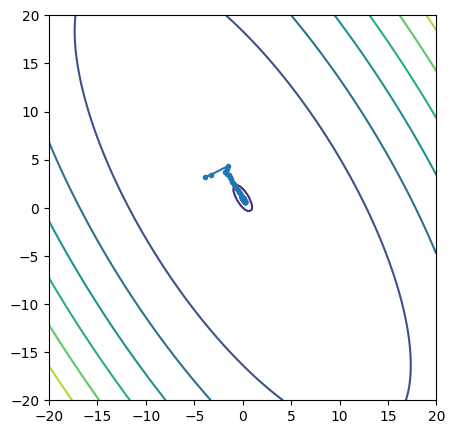

In [7]:
fs = []
fy = []
proxParams = {'v':d, 'x':x0, 'tau':0.01}

dF = lambda x : (C.T).dot(C.dot(x)-d)
xmin, stopIdx = aomip.pogm(C,d,x0,aomip.proximalL1,proxParams,mygrad=dF,iteration=500,callback=callback1)
print(xmin)
print(stopIdx)

plt.figure(figsize=(5,5))
axes = plt.gca()
fs_array = np.array(fs)
aomip.plotFunctionContour(aomip.myFunction, [-20, 20], 100, axes)
axes.plot(fs_array[:,0],fs_array[:,1], marker='.')
plt.show()

### Noisy data

[0.00996432 0.98005773]
647


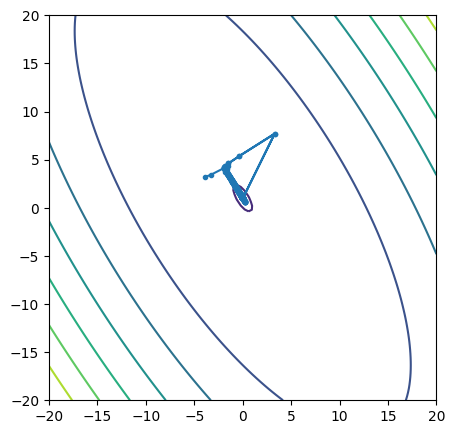

In [9]:
xmin, stopIdx = aomip.pgm(C,d,x0,aomip.proximalL1,proxParams,iteration=1000,callback=callback1)
print(xmin)
print(stopIdx)

plt.figure(figsize=(5,5))
axes = plt.gca()
fs_array = np.array(fs)
aomip.plotFunctionContour(aomip.myFunction, [-20, 20], 100, axes)
axes.plot(fs_array[:,0],fs_array[:,1], marker='.')
plt.show()

fpgm

[0.02490081 0.95588925]
129


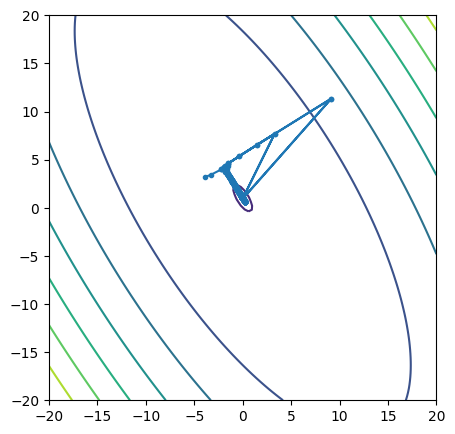

In [12]:
xmin, stopIdx = aomip.fast_pgm(C,d,x0,aomip.proximalL1,proxParams,iteration=1000,callback=callback1)
print(xmin)
print(stopIdx)

plt.figure(figsize=(5,5))
axes = plt.gca()
fs_array = np.array(fs)
aomip.plotFunctionContour(aomip.myFunction, [-20, 20], 100, axes)
axes.plot(fs_array[:,0],fs_array[:,1], marker='.')
plt.show()

## Homework 3: Low Dose X-ray CT

(i) Data preprocessing

In [76]:
def load_tiff_stack_with_metadata(file):
    if not (file.name.endswith('.tif') or file.name.endswith('.tiff')):
        raise FileNotFoundError('File has to be tif.')
    with tifffile.TiffFile(file) as tif:
        data = tif.asarray()
        metadata = tif.pages[0].tags["ImageDescription"].value
    metadata = metadata.replace("'", "\"")
    try:
        metadata = json.loads(metadata)
    except:
        print('The tiff file you try to open does not seem to have metadata attached.')
        metadata = None
    return data, metadata

# Read corresponding file from config 
def getData(file):
    with open("config.json", "r") as json_data_file:
        data = json.load(json_data_file)
    dataset = data["mayo_clinical"]
    data_path = (dataset["data_path"])["local"]
    file_name = dataset[file]
    file = join(data_path,file_name)
    tif_file = open(file, "rb")
    data, metadata = load_tiff_stack_with_metadata(tif_file)
    return data, metadata

# Obtain the nth projection
def getSinogram(data, index):
    return (data[:,index,:])
    
def preproccessed(sino_data, metadata):
    # reconstruction size
    image_size = [512] * 2

    # extract angles in degree
    angles = np.degrees(np.array(metadata["angles"])[: metadata["rotview"]])[::2]

    # setup some spacing and sizes
    voxel_size = 0.7 # can be adjusted
    vox_scaling = 1 / voxel_size
    vol_spacing = vox_scaling
    vol_size = image_size

    # size of detector
    det_count = sino_data.shape[:-1]
    det_spacing = vox_scaling * metadata["du"]

    # Distances from source to center, and center to detector
    ds2c = vox_scaling * metadata["dso"]
    dc2d = vox_scaling * metadata["ddo"]

    # Obtain the forward projection operator
    A = aomip.XrayOperator(
        vol_size,
        det_count,
        angles,
        ds2c,
        dc2d,
        vol_spacing = [vol_spacing]*2,
        sino_spacing = [det_spacing]
    )
    
    return A

[2023-06-26 14:42:42.250] [CircleTrajectoryGenerator] [info] creating 2D trajectory with 1152 poses in an -37.187492 degree arc
[2023-06-26 14:42:42.480] [CircleTrajectoryGenerator] [info] creating 2D trajectory with 1152 poses in an 124.6875 degree arc


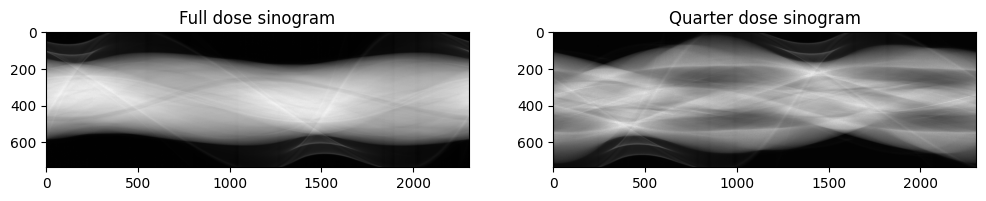

In [84]:
# full dose
datafd, metadatafd = getData('L333')
sinogramfd = getSinogram(datafd,25)
Afd = preproccessed(sinogramfd, metadatafd)
bfd = sinogramfd.flatten()

# quarter dose
dataqd, metadataqd = getData('L096')
sinogramqd = getSinogram(dataqd,25)
Aqd = preproccessed(sinogramqd, metadataqd)
bqd = (sinogramqd.flatten())[::2]

fsinofd = aomip.filter_sinogram(sinogramfd,'shepp-logan')
bfd = (fsinofd.flatten())[::2]
fsinoqd = aomip.filter_sinogram(sinogramqd,'shepp-logan')
bqd = (fsinoqd.flatten())[::2]

plt.figure(figsize=(12,12))
plt.subplot(1,2,1, title="Full dose sinogram");plt.imshow(sinogramfd,cmap='gray')
plt.subplot(1,2,2, title="Quarter dose sinogram");plt.imshow(sinogramqd,cmap='gray')
plt.show()

### Transmission log likelihood reconstruction with filtered backprojection (fbp)

It can be seen from the full dose singram, the reconstruction gives a greater constrast between the brigher image and the dark background. Besides the subtle rounded structure (could be the lesions) on the liver image. On the other hand, the quater dose reconstructed image show 2 large bean like structure in the image while the lesions are not too discernible. Moreover, the edge of the liver is not clear from the reconstructed image hence it may be hard to segment the liver. hence, better iterative reconstruction algorithm may be needed as fbp does not produce a sufficiently good reconstruction.

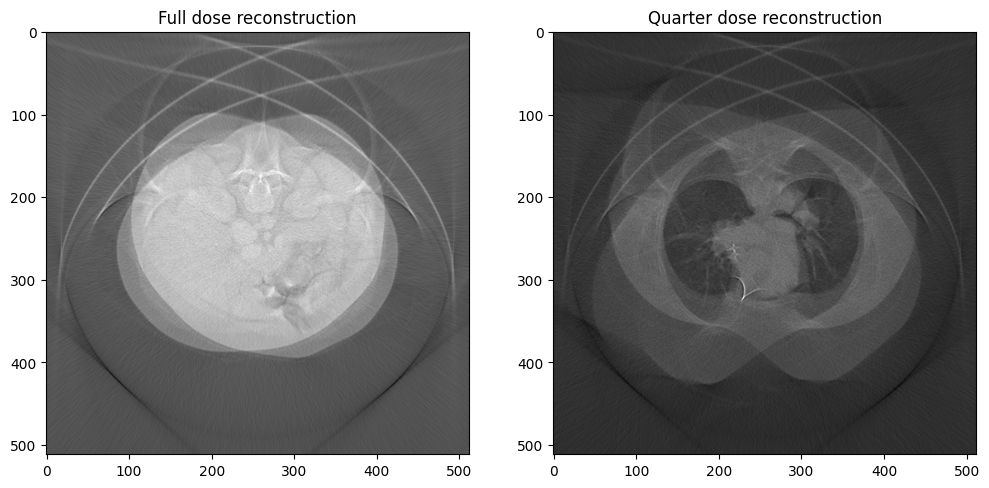

In [87]:
fbp_fd = Afd.applyAdjoint(bfd)
fbp_qd = Aqd.applyAdjoint(bqd)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1, title="Full dose reconstruction");plt.imshow(fbp_fd,cmap='gray')
plt.subplot(1,2,2, title="Quarter dose reconstruction");plt.imshow(fbp_qd,cmap='gray')
plt.show()

In [17]:
# Assume blank scan
b = np.ones_like(bfd) * 1e+8
img_vector = 512*512
x0 = np.random.rand(img_vector)
# Gradient of descent algorithm, equation (5) from sheet
df = lambda x : (Afd.T).dot(bfd - np.exp(-A.dot(x)))

# full dose reconstruction with pogm
fs = []
fy = []
proxParams = {'v':x0, 'x':x0, 'beta':1, 'delta': 10 }
#exp1, stopIdx = aomip.pogm(Afd,bfd,x0,aomip.proximalHuber,proxParams,beta=0,mygrad=df,iteration=5,callback=False)
print('Iteration: ',stopIdx )

Iteration:  309
